In [12]:
!pip install torch torchvision matplotlib gradio --quiet

In [13]:
import gradio as gr

In [14]:
!unzip wikiart10.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: wikiart10/train/Romanticism/joseph-wright_three-persons-viewing-the-gladiator-by-candlelight.jpg  
  inflating: __MACOSX/wikiart10/train/Romanticism/._joseph-wright_three-persons-viewing-the-gladiator-by-candlelight.jpg  
  inflating: wikiart10/train/Romanticism/john-william-waterhouse_the-naiad-1893.jpg  
  inflating: __MACOSX/wikiart10/train/Romanticism/._john-william-waterhouse_the-naiad-1893.jpg  
  inflating: wikiart10/train/Romanticism/edward-burne-jones_theseus.jpg  
  inflating: __MACOSX/wikiart10/train/Romanticism/._edward-burne-jones_theseus.jpg  
  inflating: wikiart10/train/Romanticism/jan-matejko_devil.jpg  
  inflating: __MACOSX/wikiart10/train/Romanticism/._jan-matejko_devil.jpg  
  inflating: wikiart10/train/Romanticism/dante-gabriel-rossetti_elizabeth-siddal-1854.jpg  
  inflating: __MACOSX/wikiart10/train/Romanticism/._dante-gabriel-rossetti_elizabeth-siddal-1854.jpg  
  inflating: wikiar

In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='/content/wikiart10/train', transform=transform)

class_names = dataset.classes
print("Классы:", class_names)

Классы: ['Baroque', 'Cubism', 'Expressionism', 'Impressionism', 'Minimalism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism']


In [17]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", device)

model = resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

Устройство: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    train_loss_hist = []
    val_acc_hist = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        train_loss_hist.append(epoch_loss)

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Val Accuracy = {val_acc:.4f}")

    return train_loss_hist, val_acc_hist


In [20]:
losses, accs = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

Epoch 1: Loss = 2.1058, Val Accuracy = 0.3839
Epoch 2: Loss = 1.8151, Val Accuracy = 0.4479
Epoch 3: Loss = 1.6546, Val Accuracy = 0.4943
Epoch 4: Loss = 1.5539, Val Accuracy = 0.4861
Epoch 5: Loss = 1.4855, Val Accuracy = 0.5108


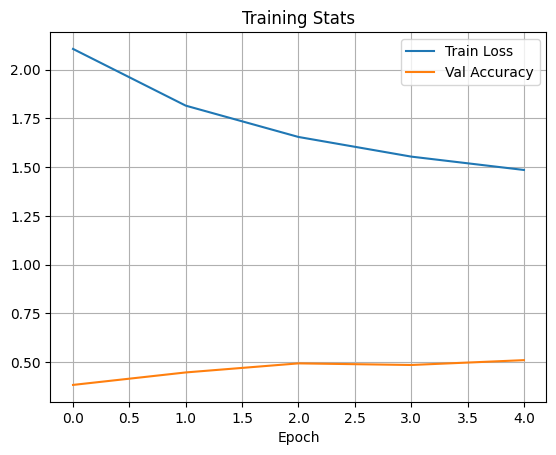

In [21]:
plt.plot(losses, label='Train Loss')
plt.plot(accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Stats")
plt.grid(True)
plt.show()


In [22]:
torch.save(model.state_dict(), "resnet50_paintingsss.pth")